#### **Name: Naftali N Indongo & Student No: 19572263**
#### **Course: Applied Machine Learning at Scale**
#### **Assessment Name: Designing a Movie Recommendation System**
#### **Due date: 15 May 2023**
-----------------------------------------------------------------

##### **Importing all the relevent libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from itertools import accumulate
from scipy.sparse import coo_matrix
import multiprocessing as mp
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Reading in the dataset
Ratings = pd.read_csv('ratings1.csv', encoding='UTF-8')
movies_df = pd.read_csv('movies1.csv')
Ratings.head()
movies_df.shape

(9742, 3)

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
A, userIds = np.unique(Ratings['userId'], return_inverse=True)
Ratings['userId'] = userIds

In [5]:
Ratings['userId'].unique()[0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
B, movieIds = np.unique(Ratings['movieId'],return_inverse=True)
Ratings['movieId'] = movieIds

In [7]:
sorted(Ratings['movieId'].unique())[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [8]:
C, m_movieIds = np.unique(movies_df['movieId'], return_inverse =  True)
movies_df['movieId'] =  m_movieIds

In [9]:
movies_df['movieId'].unique()

array([   0,    1,    2, ..., 9739, 9740, 9741])

### Inspecting the dataset

In this practical we used the  MovieLens 100K and 25M data sets which consists of user ratings and movie metadata. The Movielens 100K rating dateset  consists of 100836 movie ratings given by 610 users for 9742 movies, while the MovieLens 25M rating  data set  consists of over 25 million movie ratings provided by 162541 users for approximately 59047 movies. The data sets were collected by the GroupLens Research project at the University of Minnesota 

We will inspect the dataset info and look at a some of its rows. 

In [10]:
Ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
movies_df['tags'] = movies_df['genres'].str.split('|')
movies_df.head()

,movieId,title,genres,tags
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,2,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,4,Father of the Bride Part II (1995),Comedy,[Comedy]


### Plotting the rating distribution

The ratings range from 0.5 to 5 stars, and the distribution of ratings appears to follow a power law, with the majority of ratings falling in the 3-4 star range as shown in Figure below.


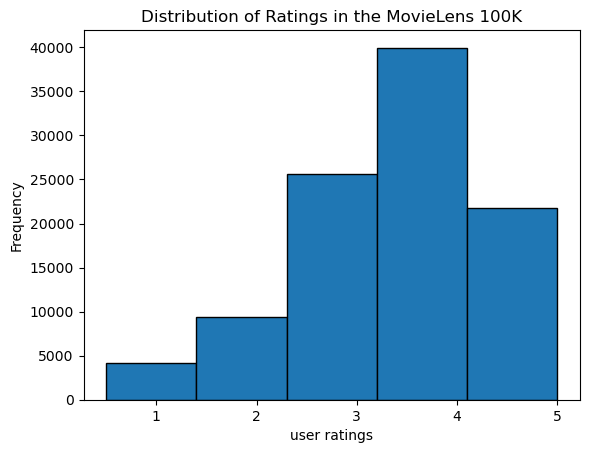

In [12]:
Ratings['rating'].hist(bins=5, ec = 'black')
plt.title('Distribution of Ratings in the MovieLens 100K')
plt.ylabel('Frequency')
plt.xlabel('user ratings')
plt.grid(False)
plt.show()

#### Power Laws

The MovieLens dataset provides a rich source of data for building and evaluating recommendation systems. We also plotted the power laws distribution for the two MovieLens datasets as shown below.

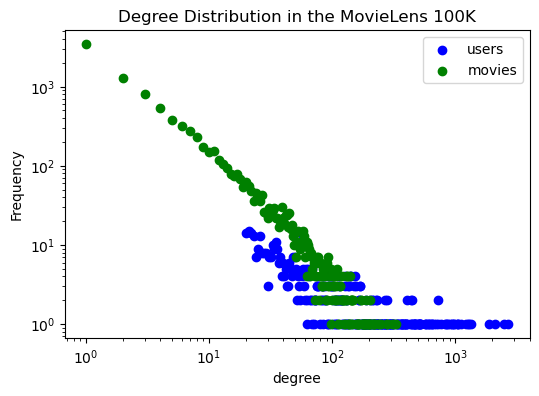

In [13]:
# Get the number of movies watched by each user
user_counts = Ratings.groupby('userId')['movieId'].count()
# Get the number of users for each movie
movie_counts = Ratings.groupby('movieId')['userId'].count()

user_deg = list(user_counts.to_dict().values())
movie_deg = list(movie_counts.to_dict().values())

user_freq = Counter(user_counts)
movie_freq = Counter(movie_counts) 

x_u, y_u = zip(*sorted(user_freq.items()))
x_m, y_m = zip(*sorted(movie_freq.items()))

# Create a scatter plot of the data
plt.figure(figsize=(6,4))
plt.scatter(x_u, y_u, color ='b',label='users')
plt.scatter(x_m, y_m,  color ='g',label='movies')
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution in the MovieLens 100K')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

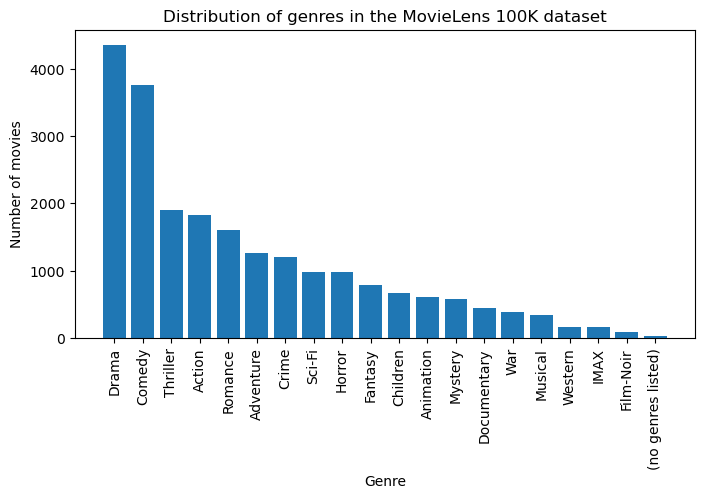

In [14]:
# Count the number of movies per genre
genre_count = movies_df['genres'].str.get_dummies(sep='|').sum()

# Sort the genre counts in descending order
genre_count = genre_count.sort_values(ascending=False)

# Plot the genre counts as a bar chart
plt.figure(figsize=(8,4))
plt.bar(genre_count.index, genre_count.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Distribution of genres in the MovieLens 100K dataset')
plt.show()

In [15]:
# Join the ratings and movies dataframes on the movieId column
movie_N_ratings = pd.merge(Ratings, movies_df, on='movieId')

# Group the movie ratings by movieId and count the number of ratings for each movie
movie_ratings_count = movie_N_ratings.groupby(['movieId', 'title'])['rating'].count()

# Sort the movies by the number of ratings in descending order and get the top 10
top_10_movies = movie_ratings_count.sort_values(ascending=False)[:10]

# Print the top 10 movies with their names
print(top_10_movies.reset_index().loc[:, ['rating', 'title']])

   rating                                      title
0     329                        Forrest Gump (1994)
1     317           Shawshank Redemption, The (1994)
2     307                        Pulp Fiction (1994)
3     279           Silence of the Lambs, The (1991)
4     278                 Walk on the Moon, A (1999)
5     251  Star Wars: Episode IV - A New Hope (1977)
6     238                       Jurassic Park (1993)
7     237                          Braveheart (1995)
8     224          Terminator 2: Judgment Day (1991)
9     220                    Schindler's List (1993)


1. Popularity: The top 10 most frequently rated movies are likely to be popular among viewers. This may suggest that these movies have broad appeal and may be good choices for marketing and promotion.

2. Age: Many of the top 10 movies were released in the 1990s, which may suggest that the dataset primarily consists of users who were active during this time period.

3. Genre: The top 10 movies represent a variety of genres, including drama, action, and science fiction. This suggests that users in the dataset have diverse tastes and interests.

4. Longevity: Some of the top 10 movies, such as "Star 
Wars: Episode IV - A New Hope" and "Jurassic Park," have been popular for several decades. This suggests that these movies have enduring appeal and may continue to be popular in the future.

Overall, the top 10 most frequently rated movies can provide valuable insights into user behavior and preferences, and can be used to inform a variety of business decisions related to the movie industry.

#### Creating the sparse matrix via the scipy library

One of the options to index the data userId and movieId is to use the build in library scipy, to create the sparse marix as shown below: 

We will first getting unique userId and movieId by using the Pandas Series.unique() function to extract the unique user and movie IDs.

In [16]:
users = Ratings['userId'].unique()
movies = Ratings['movieId'].unique()

Then create two dictionaries to store the users and movies ids.

In [17]:
user_dict = {uid: i for i, uid in enumerate(users)}
movie_dict = {iid: i for i, iid in enumerate(movies)}

This is a matrix whose corresponding rows are the userIds, columns are the movieIds and the entries are the movie ratings.

In [18]:
row = [user_dict[uid] for uid in Ratings['userId']]
col = [movie_dict[mid] for mid in Ratings['movieId']]
val = Ratings['rating'].tolist()

Finally, creating the matrix using "coo_matrix".

In [19]:
sparse_matrix = coo_matrix((val, (row, col)), shape=(len(users), len(movies)))

In [20]:
print("Our matrix store user ratings for {} users  corresponding to {} movies".format(sparse_matrix.shape[0],sparse_matrix.shape[1]))

Our matrix store user ratings for 610 users  corresponding to 9724 movies


To view the entries of the matrix, we have to convert the sparse matrix to a dense matrix.

In [21]:
user_movie_ratings = sparse_matrix.toarray()
user_movie_ratings

array([[4. , 4. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 0. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 5. , ..., 3. , 3.5, 3.5]])

In [22]:
print(user_movie_ratings.shape)

(610, 9724)


Creating the dense matrix to a pandas dataframe.

In [23]:
Spare_DF = pd.DataFrame(user_movie_ratings)
Spare_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Writing data structure that indexes the data by user and movies**

Below we will come up with data structure that indexes the data by userId and movieId. The best option to index the data using userId and movieId use double indexing to store both each user rating and movie rating in lists. We first created a list consisting of all 

##### **Index by userIds**
The dataset is already grouped by userIds, we will therefore extract the movieIds and ratings then store them in a list called U_movies_ratings. This list we have all the movies watched by every user in our dataset and the ratings they gave to each movie sorted in the order of the userIds. Furthermore, to keep track of the movies watched by each user we will create two lists consisting of start and end indices for each user in the dataset.

In [24]:
# Getting the list of movies and ratings
U_movies_ratings = list(Ratings[['movieId','rating']].values)

Extracting the start and end indices for userId and movieId

In [25]:
# define lambda functions to extract the start and end indices
get_strt_indx  = lambda x: x.index[0]
get_end_indx = lambda x: x.index[-1]

In [26]:
# applying the lambda function to the get the user start and end indices
user_strtsIdx = list(Ratings.groupby('userId').apply(get_strt_indx))
user_endsIdx = list(Ratings.groupby('userId').apply(get_end_indx))
print(user_strtsIdx[0:20])
print(user_endsIdx[0:20])

[0, 232, 261, 300, 516, 560, 874, 1026, 1073, 1119, 1259, 1323, 1355, 1386, 1434, 1569, 1667, 1772, 2274, 2977]
[231, 260, 299, 515, 559, 873, 1025, 1072, 1118, 1258, 1322, 1354, 1385, 1433, 1568, 1666, 1771, 2273, 2976, 3218]


##### **Index by MovieIds**
In order to index the dataset by movies, we first group the dataset by movieID and sort all the userIds corresponding to each movieId in ascending order. We then extract userIds and ratings in a list to store the users who watched the movies and the ratings they gave to each movie sorted in the order of the movieIds. Lastly, to keep track of the users who watched a specific movie we create two lists consisting of start and end indices for each movie in the dataset.

In [27]:
# Sort the DataFrame by movieIds in ascending order
Ratings_by_mIDs = Ratings.sort_values(['movieId', 'userId'])
Ratings_by_mIDs = Ratings_by_mIDs.reset_index(drop=True)
# Print the sorted DataFrame
Ratings_by_mIDs.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,4,0,4.0,847434962
2,6,0,4.5,1106635946
3,14,0,2.5,1510577970
4,16,0,4.5,1305696483


In [28]:
# Getting the list of users and ratings
M_users_ratings = list(Ratings_by_mIDs[['userId','rating']].values)

In [29]:
# applying the lambda function to the get the movie start and end indices
movie_strtsIdx = list(Ratings_by_mIDs.groupby('movieId').apply(get_strt_indx))
movie_endsIdx = list(Ratings_by_mIDs.groupby('movieId').apply(get_end_indx))
print(movie_strtsIdx[0:20])
print(movie_endsIdx[0:20])

[0, 215, 325, 377, 384, 433, 535, 589, 597, 613, 745, 815, 834, 842, 860, 873, 955, 1022, 1042, 1130]
[214, 324, 376, 383, 432, 534, 588, 596, 612, 744, 814, 833, 841, 859, 872, 954, 1021, 1041, 1129, 1144]


#### **Building a Model that finds MLE for user + Item baises with Alternating Least Squares**

##### **Helper functions for user_movie_ratings and movie_user_ratings**

Below are some help functions to assist us to retrieve the movies watched by each user and the ratings they gave to these movies, as well each movies and the users who watched the given movie and their ratings in a list of tupples.

In [106]:
# Extracting the number of unique users and movies.
M = len(Ratings['userId'].unique())
N = len(Ratings['movieId'].unique())

In [31]:
# Defining the function to get (movieId, rating) pairs for a given user
def get_m_movies_ratings(m):
    m_movies_ratings = U_movies_ratings[user_strtsIdx[m]:user_endsIdx[m]+1]
    return m_movies_ratings

def get_n_users_ratings(n):
    n_users_ratings = M_users_ratings[movie_strtsIdx[n]:movie_endsIdx[n]+1]
    return n_users_ratings

print(len(get_m_movies_ratings(0)))
print(len(get_n_users_ratings(0)))

232
215


In [107]:
# Initializing the user and item bias terms to small random values
user_bias = np.zeros(M) 
item_bias = np.zeros(N)

## Defining the regularization parameters
lamda = 0.3
alpha = 0.03


# Define maximum number of iterations and convergence threshold
N_iterations = 30
tol = 1e-3

# Initialize iteration counter and convergence flag
iter_count = 0
converged = False

# Lists to store loss and RMSE values over iterations
LOSS = []
RMSE = []

# Main loop for alternating least squares
while iter_count < N_iterations:
    # Fix user biases and solve for item biases
    for m in range(M):
        numerator = 0
        denominator = alpha
        m_movies_n_ratings = U_movies_ratings[user_strtsIdx[m]:user_endsIdx[m]+1]#get_m_movies_ratings(m)
        for n,r in m_movies_n_ratings:
            numerator+=lamda*(r- item_bias[int(n)])
            denominator+= lamda
        user_bias[m] = numerator/denominator

    # Fix user biases and solve for item biases
    for n in range(N):
        numerator = 0
        denominator = alpha
        n_users_n_ratings =  M_users_ratings[movie_strtsIdx[n]:movie_endsIdx[n]+1]#get_n_users_ratings(n)
        for m,r in n_users_n_ratings:
            numerator += lamda*(r - user_bias[int(m)])  # subtract user bias
            denominator += lamda
        item_bias[n] = numerator/denominator


    # Compute total loss and RMSE
    loss = -0.5 * lamda*np.sum((Ratings['rating'] - (user_bias[Ratings['userId']] + item_bias[Ratings['movieId']])) ** 2)
    loss -= 0.5 * alpha*(np.sum(user_bias ** 2) + np.sum(item_bias ** 2))
    rmse = np.sqrt(np.mean((Ratings['rating'] - (user_bias[Ratings['userId']] + item_bias[Ratings['movieId']])) ** 2))

    print(f'Iteration {iter_count}: loss = {loss:.3f}, RMSE = {rmse:.6f}')
    LOSS.append(loss)
    RMSE.append(rmse)

    iter_count += 1

Iteration 0: loss = -9982.084, RMSE = 0.804289
Iteration 1: loss = -9582.018, RMSE = 0.787351
Iteration 2: loss = -9555.015, RMSE = 0.786098
Iteration 3: loss = -9552.305, RMSE = 0.785955
Iteration 4: loss = -9551.650, RMSE = 0.785928
Iteration 5: loss = -9551.228, RMSE = 0.785921
Iteration 6: loss = -9550.847, RMSE = 0.785918
Iteration 7: loss = -9550.479, RMSE = 0.785917
Iteration 8: loss = -9550.119, RMSE = 0.785916
Iteration 9: loss = -9549.766, RMSE = 0.785916
Iteration 10: loss = -9549.421, RMSE = 0.785916
Iteration 11: loss = -9549.082, RMSE = 0.785916
Iteration 12: loss = -9548.750, RMSE = 0.785915
Iteration 13: loss = -9548.424, RMSE = 0.785915
Iteration 14: loss = -9548.104, RMSE = 0.785915
Iteration 15: loss = -9547.791, RMSE = 0.785915
Iteration 16: loss = -9547.484, RMSE = 0.785915
Iteration 17: loss = -9547.182, RMSE = 0.785915
Iteration 18: loss = -9546.887, RMSE = 0.785914
Iteration 19: loss = -9546.597, RMSE = 0.785914
Iteration 20: loss = -9546.313, RMSE = 0.785914
It

### Building a Model that finds MLE for user + Item baises with Alternating Least Squares

Plotting the loss and RMSE

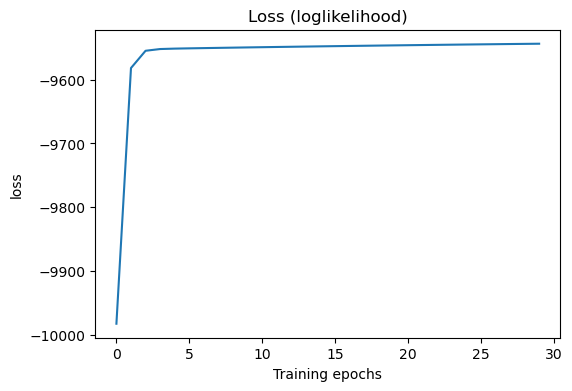

In [108]:
plt.figure(figsize=(6,4))
plt.plot(LOSS)
plt.xlabel('Training epochs')
plt.ylabel('loss')
plt.title('Loss (loglikelihood)')
plt.show()


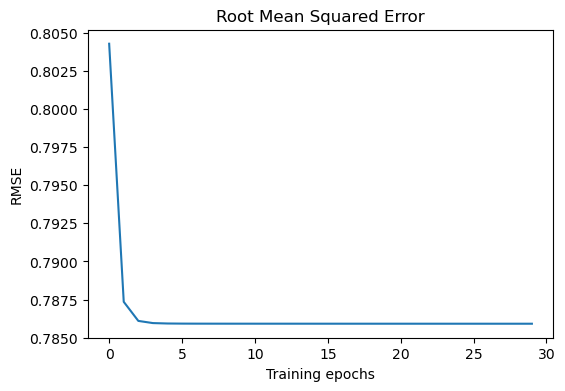

In [109]:
plt.figure(figsize=(6,4))
plt.plot(RMSE)
plt.xlabel('Training epochs')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error')
plt.show()

### Building a Model that finds MLE for user + Item baises + latent trait vectors/factors with Alternating Least Squares

In [36]:
# Initialize user and item bias to zero
user_bias = np.zeros(M) 
item_bias = np.zeros(N) 

# Defining the regularization parameters
alpha = 0.09
lamda = 0.001
tau = 0.01
tol = 1e-4

# Define number of latent dimensions and number of iterations
K = 20

iter_count = 0
# Initialize user and item latent factor matrices to small random values
mu,sigma = 0, 2.5/np.sqrt(K) #mean rating and standard deviation 
user_factors = np.random.normal(mu, sigma, (M, K)) 
item_factors = np.random.normal(mu, sigma, (N, K))
np.random.seed(10)

# Defining the driver fuction for computing the loss as negative log likelihood
def loss_function():
   predicted_ratings = np.zeros(len(Ratings))
   U_T_V, U_U_T, V_V_T, U_bias, I_bias =  np.zeros(len(Ratings)), np.zeros(len(Ratings)), np.zeros(len(Ratings)), np.zeros(len(Ratings)), np.zeros(len(Ratings))
   for i, row in Ratings.iterrows():
     U_T_V[i] = np.dot(user_factors[int(row['userId'])], item_factors[int(row['movieId'])])
     U_U_T[i] = np.dot(user_factors[int(row['userId'])], user_factors[int(row['userId'])])
     V_V_T[i] = np.dot(item_factors[int(row['movieId'])], item_factors[int(row['movieId'])])
     predicted_ratings[i] = user_bias[int(row['userId'])] + item_bias[int(row['movieId'])] + \
                            np.dot(user_factors[int(row['userId'])], item_factors[int(row['movieId'])])
     U_bias[i] = user_bias[int(row['userId'])]**2
     I_bias[i] = item_bias[int(row['movieId'])]**2
   loss = -0.5*lamda*np.sum((Ratings['rating'] - predicted_ratings)**2)-0.5*tau*np.sum(U_U_T)-0.5*tau*np.sum(V_V_T)- \
          0.5*alpha*np.sum(U_bias)-0.5*alpha*np.sum(I_bias)
   rmse = np.sqrt(np.sum((Ratings['rating'] - predicted_ratings)**2)/len(Ratings))
   return loss, rmse

# Empty lists to store the loss and rmse
LOSS = []
RMSE = []
N_iterations = 30
#Begining of the ALS algorithm
for iteration in range(N_iterations):
        # Fix item biases and latent factors/vectors and update the user biases and latent factors/vectors
        for m in range(M):
            # select movies watched and rated by user m 
            m_movies_n_ratings = U_movies_ratings[user_strtsIdx[m]:user_endsIdx[m]+1]
            
            # update user biases
            numerator = 0
            denominator = alpha
            #movies watched by user m and their ratings.
            for n,r in m_movies_n_ratings:
                numerator += lamda*(r - np.dot(user_factors[m], item_factors[int(n)])-item_bias[int(n)]) 
                denominator += lamda
            user_bias[m] = numerator / denominator #update user m's bias

            # Update the user latent factors/vectors
            numerator = np.zeros(K)
            denominator = tau * np.eye(K)
            for n,r in m_movies_n_ratings:
                numerator += lamda*(r - user_bias[m] - item_bias[int(n)]) * item_factors[int(n)]
                denominator += lamda*np.outer(item_factors[int(n)], item_factors[int(n)])
            user_factors[m] = np.linalg.solve(denominator, numerator) #update user m's factor

        # Fix user biases and latent factors/vectors and update the item biases and latent factors/vectors
        for n in range(N):
            # select users who watched and rated movie n
            n_users_n_ratings =  M_users_ratings[movie_strtsIdx[n]:movie_endsIdx[n]+1] 

            #update item biases
            numerator = 0
            denominator = alpha
            for m,r in n_users_n_ratings:
                numerator += lamda*(r - np.dot(user_factors[int(m)],  item_factors[n])- user_bias[int(m)]) 
                denominator += lamda
            item_bias[n] = numerator / denominator #update item n's bias

            # update item latent vectors/factors
            numerator = np.zeros(K)
            denominator = tau*np.eye(K)
            for m,r in n_users_n_ratings:
                numerator += lamda*(r - user_bias[int(m)]-item_bias[n])*user_factors[int(m)]
                denominator += lamda*np.outer(user_factors[int(m)], user_factors[int(m)])
            item_factors[n] = np.linalg.solve(denominator, numerator) # update item n's latent factor/vector

        # Compute the loss and RMSE
        loss, rmse = loss_function()

        LOSS.append(loss)
        RMSE.append(rmse)
        print(loss,rmse)
        iter_count += 1
print(f'The algorithm converged after {iter_count} iterations with a loss of {loss:.4f} and RMSE of {rmse:.4f}')

-33743.522055160385 1.0040960592482588
-26855.20696555663 0.7962208328558382
-22911.936809752344 0.7168857007816891
-20409.033350477774 0.688113132716116
-18561.059618068673 0.6761611145328612
-17171.75022397535 0.6699472553434607
-16114.707060151837 0.6662388502727841
-15297.100641841214 0.6638573146962871
-14654.283167850088 0.6622524742870523
-14141.515619444996 0.6611257842369713
-13727.285952219876 0.6603021813905398
-13388.916966084018 0.6596753184252508
-13109.77633402901 0.6591794216779965
-12877.464606105006 0.6587732386291483
-12682.601459815975 0.6584305203979705
-12517.993580861099 0.6581342965468937
-12378.054781574763 0.6578734037562679
-12258.39646965106 0.6576403620868576
-12155.534702286877 0.6574300546711883
-12066.677804505067 0.6572388880303077
-11989.570171649644 0.6570642471266884
-11922.375686967087 0.6569041398046934
-11863.5894665779 0.6567569690114731
-11811.97020382389 0.6566213933536122
-11766.487766517692 0.656496247786568
-11726.282285324842 0.656380502867

Plotting the loss and RMSE

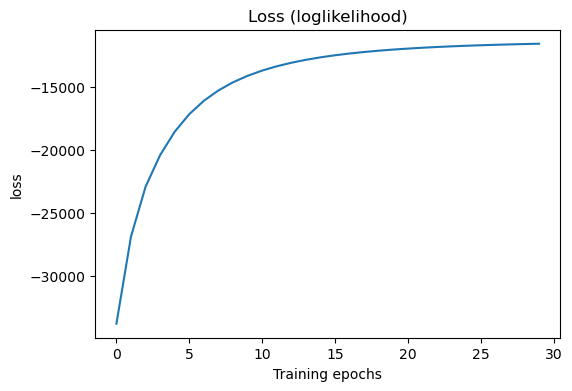

In [37]:
plt.figure(figsize=(6,4))
plt.plot(LOSS)
plt.xlabel('Training epochs')
plt.ylabel('loss')
plt.title('Loss (loglikelihood)')
plt.show()

Plotting the Room Mean Square Error

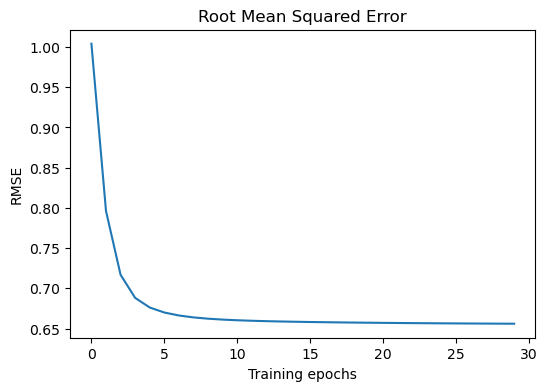

In [38]:
#plotting the RMSE
plt.figure(figsize=(6,4))
plt.plot(RMSE)
plt.xlabel('Training epochs')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error')
plt.show()

#### Parallelization

In [40]:
from multiprocessing import Pool

# Set the number of cores to use
num_cores = mp.cpu_count()

# Define a function to update user biases and factors in parallel
def update_user(m):
    # select movies watched and rated by user m 
    m_movies_n_ratings = U_movies_ratings[user_strtsIdx[m]:user_endsIdx[m]+1]
            
    # update user biases
    numerator = 0
    denominator = alpha
    #movies watched by user m and their ratings.
    for n,r in m_movies_n_ratings:
        numerator += lamda*(r - np.dot(user_factors[m], item_factors[int(n)])-item_bias[int(n)]) 
        denominator += lamda
    user_bias[m] = numerator / denominator #update user m's bias

    # Update the user latent factors/vectors
    numerator = np.zeros(K)
    denominator = tau * np.eye(K)
    for n,r in m_movies_n_ratings:
        numerator += lamda*(r - user_bias[m] - item_bias[int(n)]) * item_factors[int(n)]
        denominator += lamda*np.outer(item_factors[int(n)], item_factors[int(n)])
    user_factors[m] = np.linalg.solve(denominator, numerator) #update user m's factor

    return user_bias, user_factors

# Define a function to update item biases and factors in parallel
def update_item(n):
    # select users who watched and rated movie n
    n_users_n_ratings =  M_users_ratings[movie_strtsIdx[n]:movie_endsIdx[n]+1] 

    #update item biases
    numerator = 0
    denominator = alpha
    for m,r in n_users_n_ratings:
        numerator += lamda*(r - np.dot(user_factors[int(m)],  item_factors[n])- user_bias[int(m)]) 
        denominator += lamda
    item_bias[n] = numerator / denominator #update item n's bias

    # update item latent vectors/factors
    numerator = np.zeros(K)
    denominator = tau*np.eye(K)
    for m,r in n_users_n_ratings:
        numerator += lamda*(r - user_bias[int(m)]-item_bias[n])*user_factors[int(m)]
        denominator += lamda*np.outer(user_factors[int(m)], user_factors[int(m)])
    item_factors[n] = np.linalg.solve(denominator, numerator) # update item n's latent factor/vector
    return item_bias, item_factors


#Begining of the ALS algorithm
# Begining of the ALS algorithm
for iteration in range(N_iterations):
    # Fix item biases and latent factors/vectors and update the user biases and latent factors/vectors
    with Pool(processes=num_cores) as pool:
        pool.map(update_user, range(M))

    # Fix user biases and latent factors/vectors and update the item biases and latent factors/vectors
    with Pool(processes=num_cores) as pool:
        pool.map(update_item, range(N))

    # Compute the loss and RMSE
    loss, rmse = loss_function()

    LOSS.append(loss)
    RMSE.append(rmse)
    iter_count += 1

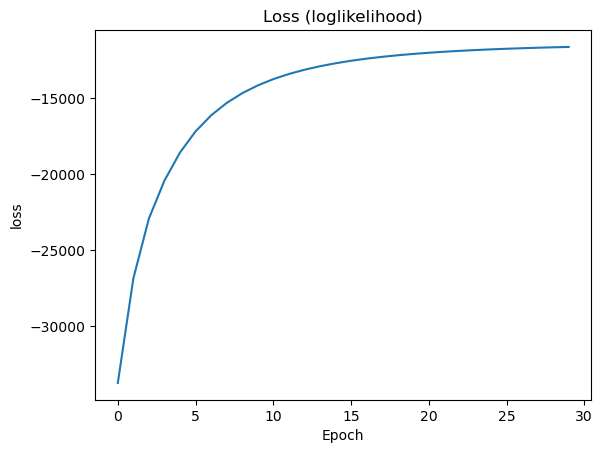

In [41]:
plt.plot(LOSS)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss (loglikelihood)')
plt.show()

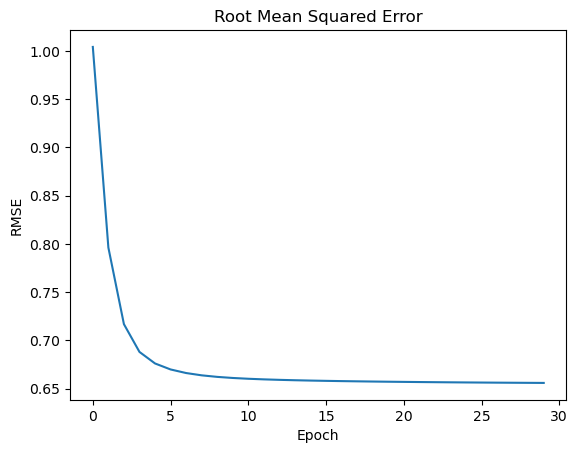

In [42]:
#plotting the RMSE
plt.plot(RMSE)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error')
plt.show()

## Feature Embeddings

In a recommendation system, we might want to map users and items into a lower-dimensional space so that we can visualize how they relate to each other and make recommendations based on their similarity. After training the ALS algorithm, plotting the embeddings in a 2D space can give us insights into how users and items are related to each other based on their latent factors as shown below:

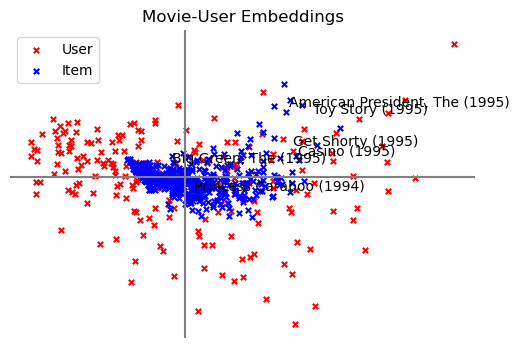

In [43]:
#Get the list of all movie titles
movie_titles = list(movies_df['title'])

# Select a random subset of 200 users and 500 movies
np.random.seed(44)
movie_subset = np.random.choice(N, size=500, replace=False)
user_subset = np.random.choice(M, size=200, replace=False)

# apply PCA to the item features and users embeddings separately
pca_item = PCA(n_components=2)
pca_user = PCA(n_components=2)
X_item_pca = pca_item.fit_transform(item_factors)
X_user_pca = pca_user.fit_transform(user_factors)

fig, ax = plt.subplots(figsize=(6, 4))

# add a line at x=0 and y=0
ax.axhline(y=0, color='gray', linestyle='-')
ax.axvline(x=0, color='gray', linestyle='-')

# Plot the user factors embeddings in 2D
ax.scatter(X_user_pca[user_subset, 0], X_user_pca[user_subset, 1], marker = 'x', color = 'red', label = 'User', s=15)

# Plot the item factors embeddings in 2D
ax.scatter(X_item_pca[movie_subset, 0], X_item_pca[movie_subset, 1], marker='x', color ='blue', label = 'Item', s =15)
ax.legend( loc='best')
plt.title('Movie-User Embeddings')

# remove x and y axis
plt.axis('off')


# add titles for a few movies
movie_indices = [0, 10,15, 20, 49, 500] # assume these are the indices of the movies in your dataset
selected_movies = np.array(movie_titles)[movie_indices]

for title, index in zip(selected_movies, movie_indices):
    ax.text(X_item_pca[index, 0], X_item_pca[index, 1], title)


# show the plot
plt.show()


Item feautures embeddings

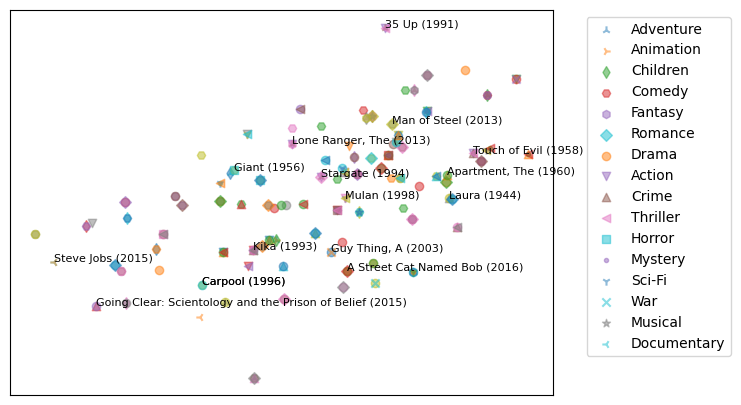

In [44]:
#Get the list of all movie titles
movie_titles = list(movies_df['title'])

# Extract the unique genre labels
genre_labels = set()
for genres in movies_df['genres']:
    genre_labels.update(genres.split('|'))
    
genre_labels = list(genre_labels)

# Encode the movie genres as binary variables using one-hot encoding
movie_genres = []
for genres in movies_df['genres']:
    one_hot = np.zeros(len(genre_labels))
    for genre in genres.split('|'):
        one_hot[genre_labels.index(genre)] = 1
    movie_genres.append(one_hot)

movie_genres = np.array(movie_genres)


# create a dictionary mapping genres to markers
genres_markers = {}
markers = ['o','.',',','x','+','v','^','<','>','1','2','3','4','s','p','*','h','H','D','d']
for i in range(len(genre_labels)):
    genres_markers[genre_labels[i]] = markers[i]
genres_markers

# Select 50 randomly sampled movie titles and their corresponding one-hot encoded genres
n_movies =100
np.random.seed(14)
idx = np.random.choice(len(movie_titles), n_movies, replace=False)
selected_movie_titles = np.array(movie_titles)[idx]
selected_movie_genres = movie_genres[idx, :]

# apply PCA to reduce dimensionality of movie feature vectors to 2
genres = movies_df['genres'].str.split('|')
pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)

# plot the movie feature vectors embedded in R2, tagged by genre
fig, ax = plt.subplots(figsize=(7, 5))

# add a line at x=0 and y=0
# ax.axhline(y=0, color='gray', linestyle='-')
# ax.axvline(x=0, color='gray', linestyle='-')

legend_labels = []
# plot the movie feature vectors embedded in R2, tagged by genre
for i in range(n_movies):
    for genre in genres[i]:
        marker = genres_markers.get(genre)
        marker_index = markers.index(marker)
        if genre not in legend_labels:
            ax.scatter(item_factors_2d[i, 0], item_factors_2d[i, 1], marker=marker, label=genre, alpha=0.5)
            legend_labels.append(genre)
        else:
             ax.scatter(item_factors_2d[i, 0], item_factors_2d[i, 1], marker=marker, alpha=0.5)
             
        
        # Add title for 10 randomly selected movies in our sampled movie list. 
        if i in np.random.choice(range(n_movies), 7):
            ax.text(item_factors_2d[i, 0], item_factors_2d[i, 1], selected_movie_titles[i], fontsize=8)
        
# Add the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='best')

# remove the axis
# remove x and y ticks and labels
ax.tick_params(axis='both', which='both', length=0, width=0, labelbottom=False, labelleft=False)



# show the plot
plt.show()

### Making Some Recommendations

To recommend movies to a user based on the movies they watched, we can use collaborative filtering techniques by exploiting the similarities between users or items to generate personalized recommendations. To approach this, we will  make use of the user-item matrix generated during the ALS algorithm training to predict ratings for unseen movies based on the user's previous ratings and similar users' ratings. We can then recommend the movies with the highest predicted ratings to the user.

In [45]:
predicted_ratings = np.dot(user_factors, item_factors.T)
predicted_ratings.shape

(610, 9724)

#### **Denstrating the Napolean Dynamite effect**
The "Napoleon Dynamite effect" is a phenomenon where certain movies receive extremely high or extremely low ratings despite their overall quality. To demonstrate this effect after training an ALS model, we will calculate the average rating for each movie and plot the distribution of ratings as shown below:

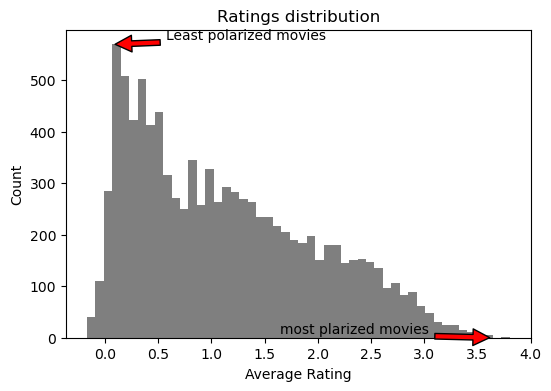

In [46]:
# calculate the average rating for each movie
Mean_ratings = np.mean(predicted_ratings, axis = 0)

# plot the distribution of movie ratings
plt.figure(figsize=(6,4))
plt.hist(Mean_ratings, bins=50, color='green')

# add annotation for the minimum value
min_val = np.min(plt.hist(Mean_ratings, bins=50)[0])
min_index = np.argmin(plt.hist(Mean_ratings, bins=50)[0])
plt.annotate('most plarized movies', xy=(plt.hist(Mean_ratings, bins=50)[1][min_index], min_val), xytext=(plt.hist(Mean_ratings, bins=50)[1][min_index]-2.0, min_val+9), arrowprops=dict(facecolor='red', shrink=0.05))

# add annotation for the maximum value
max_val = np.max(plt.hist(Mean_ratings, bins=50)[0])
max_index = np.argmax(plt.hist(Mean_ratings, bins=50)[0])
plt.annotate('Least polarized movies', xy=(plt.hist(Mean_ratings, bins=50)[1][max_index], max_val), xytext=(plt.hist(Mean_ratings, bins=50)[1][max_index]+0.5, max_val+10), arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Ratings distribution')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

In [47]:
movie_variances = np.var(predicted_ratings, axis = 0)
least_polarizing = movie_variances.argsort()[0:10]
least_polarizing_movies = movies_df[movies_df['movieId'].isin(least_polarizing)]['title'].tolist()
print('The least polarized movies are:')
print('##############################')
print("\n".join(least_polarizing_movies))

# The top 10 most polarized movies
most_polarizing =movie_variances.argsort()[::-1][0:10]
most_polarizing_movies = movies_df[movies_df['movieId'].isin(most_polarizing)]['title'].tolist()
print('\nThe least polarized movies are:')
print('###############################')
print("\n".join(most_polarizing_movies))

The least polarized movies are:
##############################
Ladies Man, The (2000)
Crossroads (2002)
Anne of the Thousand Days (1969)
Super Size Me (2004)
Me and You and Everyone We Know (2005)
Superbad (2007)
I Love You, Man (2009)
5 to 7 (2014)
April Morning (1988)
Band of Brothers (2001)

The least polarized movies are:
###############################
Braveheart (1995)
Pulp Fiction (1994)
Independence Day (a.k.a. ID4) (1996)
Lawrence of Arabia (1962)
Mr. Magoo (1997)
Mister Roberts (1955)
Lord of the Flies (1963)
White Water Summer (1987)
Shark Night 3D (2011)
Safe (2012)


For each user, we would like to only recommend the movies that a user did not watch.

In [48]:
def Top_N_recommeded_to_user(user_id,num_recommendations):
    #user_m's predicted scores
    user_m_ratings = predicted_ratings[user_id] + user_bias[user_id] + item_bias
    #Selecting the row correspinding to the given user in the sparse matrix
    user_m_movies =  Spare_DF.iloc[user_id]
    # Select movies not watched by the given user
    unrated_movies = user_m_movies[user_m_movies==0]
    rated_movies = user_m_movies[user_m_movies!=0]
    # Select only the predicted ratings corresponding to the movies that are not watched by user_m and
    # Sort the unwatched movies in the order of their predicted ratings scores to extract the top movieId.
    Recommended_mIds = user_m_ratings[unrated_movies.index].argsort()

    #Getting the top N recommended movies
    recommended_movies = Recommended_mIds[:num_recommendations]
    return rated_movies, recommended_movies

In [49]:
#Test
user_id = 10
num_recommendations =  10
watched_movies, recommended_movies =  Top_N_recommeded_to_user(user_id,num_recommendations)
recommended_movie_titles = movies_df.loc[(movies_df['movieId'].isin(recommended_movies))&(movies_df['movieId']!=user_id)]['title'].tolist()
titles, Genres, average_rating, mIds = [], [], [], []
for title in recommended_movie_titles:
    movie_id = movies_df[movies_df['title']==title]['movieId'].values[0]
    avrg_rating = round(Spare_DF[movie_id].sum()/np.count_nonzero(Spare_DF[movie_id]),1)
    genre = movies_df[movies_df['title']==title]['genres'].values[0]
    titles.append(title), Genres.append(genre), average_rating.append(avrg_rating), mIds.append(movie_id)
    #print("{}: {} Average rating: {:.2f}".format(title, genre,avrg_rating))

Recommendations = pd.DataFrame({'movieId':mIds, 'Title': titles, 'Genres': Genres, 'Average Rating': average_rating})
print('The top 10 recommended movies for a user whose userId = {} are:'.format(user_id))
Recommendations


The top 10 recommended movies for a user whose userId = 10 are:


,movieId,Title,Genres,Average Rating
0,3004,"Gift, The (2000)",Thriller,3.5
1,3014,"Everlasting Piece, An (2000)",Comedy,2.6
2,3983,Secretary (2002),Comedy|Drama|Romance,3.5
3,5477,Zabriskie Point (1970),Drama|Romance,4.5
4,6582,"Lust, Caution (Se, jie) (2007)",Drama|Romance|Thriller|War,3.0
5,6768,Spiral (2007),Drama|Horror|Thriller,3.8
6,7081,Open Water 2: Adrift (2006),Drama|Thriller,3.0
7,7108,G-Force (2009),Action|Adventure|Children|Fantasy,4.0
8,8598,La Belle Verte (1996),Comedy,3.5
9,9039,The Unauthorized Saved by the Bell Story (2014),Comedy|Drama,1.5


In [50]:

print('The movies watched by the user whose userId = {} are:'.format(user_id))
# select movies whose movieIds are in the watched movie list
selected_movies = movies_df[movies_df['movieId'].isin(watched_movies.index)]
selected_movies[['movieId', 'title', 'genres']]


The movies watched by the user whose userId = 10 are:


,movieId,title,genres
2,2,Grumpier Old Men (1995),Comedy|Romance
7,7,Tom and Huck (1995),Adventure|Children
19,19,Money Train (1995),Action|Comedy|Crime|Drama|Thriller
20,20,Get Shorty (1995),Comedy|Crime|Thriller
25,25,Othello (1995),Drama
...,...,...,...
988,988,Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out ...,Documentary
989,989,Some Kind of Wonderful (1987),Drama|Romance
990,990,Indiana Jones and the Last Crusade (1989),Action|Adventure
991,991,Being There (1979),Comedy|Drama


Often in online movies platforms such as Netflix and X-box, after watching a certain movie, a user is always recommended some movies to watch. In our recommendation system, we would also like to showcase this idea by making recommendations based on a movie that a certain user just watched. e.g. user 10 just finished watching "Toy Story (1995)" what should the top recommedations be?

In [51]:
def Top_N_recommeded_to_user_by_watched_movie(user_id, watched_movie_title, num_recommendations):
    watched_movie_id = movies_df[movies_df['title'] == watched_movie_title]['movieId'].values[0]

    # retrieveing the item_factors corresponding to the given movie
    watched_movie_factors = item_factors[watched_movie_id]
    #compute the similarity between the watched movie and other movies in the dataset.
    similarities = item_factors @ watched_movie_factors

    #Selecting the row correspinding to the given user
    user_m_movies =  Spare_DF.iloc[user_id]
    # Movies not watched by the given user
    unrated_movies = user_m_movies[user_m_movies==0]
    rated_movies = user_m_movies[user_m_movies!=0]

    #Getting the top N movies similar to the watched movie
    mimilar_movies = similarities[unrated_movies.index] #Getting the ratings of the movies that the user did not watch.
    Top_N_similar_movies = mimilar_movies.argsort()[::-1][:num_recommendations]
    return Top_N_similar_movies, rated_movies

In [52]:
user_id = 16
num_recommendations = 10
watched_movie = "Toy Story (1995)"
Top_N_similar_movies, watched_movies = Top_N_recommeded_to_user_by_watched_movie(user_id, watched_movie, num_recommendations)

recommended_movie_titles = movies_df.loc[movies_df['movieId'].isin(Top_N_similar_movies)]['title'].tolist()
titles, Genres, average_rating, mIds = [], [], [], []
for title in recommended_movie_titles:
    movie_id = movies_df[movies_df['title']==title]['movieId'].values[0]
    avrg_rating = round(Spare_DF[movie_id].sum()/np.count_nonzero(Spare_DF[movie_id]),1)
    genre = movies_df[movies_df['title']==title]['genres'].values[0]
    titles.append(title), Genres.append(genre), average_rating.append(avrg_rating), mIds.append(movie_id)
  
Recommendations = pd.DataFrame({'movieId':mIds, 'Title': titles, 'Genres': Genres, 'Average Rating': average_rating})
print('The top 10 recommended movies for user {} who watched {}:'.format(user_id, watched_movie))
Recommendations

The top 10 recommended movies for user 16 who watched Toy Story (1995):


,movieId,Title,Genres,Average Rating
0,33,Dead Man Walking (1995),Crime|Drama,3.4
1,186,Boys on the Side (1995),Comedy|Drama,3.0
2,267,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,3.8
3,275,Stargate (1994),Action|Adventure|Sci-Fi,2.6
4,345,Boys Life (1995),Drama,3.4
5,405,Live Nude Girls (1995),Comedy,3.9
6,448,Radioland Murders (1994),Comedy|Mystery|Romance,2.0
7,452,Rising Sun (1993),Action|Drama|Mystery,3.4
8,902,Aliens (1986),Action|Adventure|Horror|Sci-Fi,3.7
9,972,Down by Law (1986),Comedy|Drama|Film-Noir,3.2


In [53]:
print('The movies watched by the user whose userId = {} are:'.format(user_id))
# select movies whose movieIds are in the watched movie list
selected_movies = movies_df[movies_df['movieId'].isin(watched_movies.index)]
selected_movies[['movieId', 'title', 'genres']]

The movies watched by the user whose userId = 16 are:


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy
7,7,Tom and Huck (1995),Adventure|Children
15,15,Casino (1995),Crime|Drama
...,...,...,...
1150,1150,Romy and Michele's High School Reunion (1997),Comedy
1151,1151,Temptress Moon (Feng Yue) (1996),Romance
1152,1152,Volcano (1997),Action|Drama|Thriller
1153,1153,Children of the Revolution (1996),Comedy


In [55]:
#Reduce the movies_df so that it only contain movie_ids in the rating.csv file.
movies_df1 = movies_df.head(item_factors.shape[0])

In [56]:
# Define the watched movie_id
watched_movie_id = 1
watched_movie_name =  movies_df1.loc[watched_movie_id]['title']
print(watched_movie_name)
def top_similar_movies(watched_movie_id):
    # Get the genre of the watched movie
    watched_movie_genres = movies_df1.loc[movies_df1['movieId'] == watched_movie_id]['genres'].values[0]

    # Find all movies with the same genre as the watched movie
    genre_movies = movies_df1[movies_df1['genres'].str.contains(watched_movie_genres)]
    #genre_movies = genre_movies.head(1972)

    # Compute the similarity scores between the watched movie and all other movies with the same genre
    watched_movie_features = item_factors[watched_movie_id]
    genre_movie_features = item_factors[genre_movies['movieId'].values]
    similarity_scores = cosine_similarity(watched_movie_features.reshape(1,-1), genre_movie_features)

    # Sort the movies by similarity score in descending order
    similar_movies_indices = np.argsort(similarity_scores, axis=1)[0][::-1]

    # Choose the top 10 movies with the highest similarity score
    top_similar_movies_indices = similar_movies_indices[1:11]
    top_similar_movie_ids = genre_movies.iloc[top_similar_movies_indices]['movieId'].values

    top_similar_movie_titles = movies_df1.loc[movies_df1['movieId'].isin(top_similar_movie_ids)]['title'].tolist()

    return top_similar_movie_titles

# Print the top 10 similar movies


Top_N_similar_movies, watched_movies = Top_N_recommeded_to_user_by_watched_movie(user_id, watched_movie, num_recommendations)

# Print the top 10 similar movies
recommended_movie_titles = top_similar_movies(watched_movie_id)
#recommended_movie_titles = movies_df.loc[movies_df['movieId'].isin(Top_N_similar_movies)]['title'].tolist()
titles, Genres, average_rating, mIds = [], [], [], []
for title in recommended_movie_titles:
    movie_id = movies_df[movies_df['title']==title]['movieId'].values[0]
    avrg_rating = round(Spare_DF[movie_id].sum()/np.count_nonzero(Spare_DF[movie_id]),1)
    genre = movies_df[movies_df['title']==title]['genres'].values[0]
    titles.append(title), Genres.append(genre), average_rating.append(avrg_rating), mIds.append(movie_id)

Recommendations = pd.DataFrame({'movieId':mIds, 'Title': titles, 'Genres': Genres, 'Average Rating': average_rating})
print('The top 10 recommended movies for user {} who watched {}:'.format(user_id, watched_movie))
Recommendations

Jumanji (1995)
The top 10 recommended movies for user 16 who watched Toy Story (1995):


,movieId,Title,Genres,Average Rating
0,14,Cutthroat Island (1995),Action|Adventure|Romance,3.7
1,53,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy,3.4
2,77,White Squall (1996),Action|Adventure|Drama,3.8
3,126,Batman Forever (1995),Action|Adventure|Comedy|Crime,3.4
4,322,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,3.8
5,365,Black Beauty (1994),Adventure|Children|Drama,3.8
6,431,Executive Decision (1996),Action|Adventure|Thriller,3.8
7,505,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller,2.5
8,549,Dragonheart (1996),Action|Adventure|Fantasy,2.9
9,594,Twister (1996),Action|Adventure|Romance|Thriller,3.3


In [59]:
# Create a dictionary mapping movie titles to movie IDs
id2title = dict(zip(movies_df1['movieId'], movies_df1['title']))

# Create a dictionary mapping movie IDs to movie titles
title2id = dict(zip(movies_df1['title'], movies_df1['movieId']))

movie_title = 'Lord of the Rings: The Fellowship of the Ring, The (2001)'
num_movies = 10

# Create a dummy user that gave "The Lord of the Rings: The Fellowship of the Ring" movie five stars
dummy_user = np.zeros(len(movies_df1))
dummy_user_id = title2id[movie_title]
dummy_user[dummy_user_id] = 5

# Get the latent factor for the "The Lord of the Rings: The Fellowship of the Ring" movie
movie_id = title2id[movie_title]
movie_factor = item_factors[movie_id]

# Compute the similarity between the "The Lord of the Rings: The Fellowship of the Ring" movie and all other movies
similarities = np.dot(dummy_user,item_factors)

# Get the top 10 most similar movies
top_10_similar_movies_indices = similarities.argsort()[::-1][:num_movies]
top_10_similar_movies = [id2title[i] for i in top_10_similar_movies_indices]

#Print the top 10 most similar movies
print("The top {} recommended movies for the user who watched {} are:".format(num_movies, movie_title))
top_10_similar_movies
Genres =  []
for movie in top_10_similar_movies:
    genre = movies_df[movies_df['title']==movie]['genres'].values[0]
    Genres.append(genre)

Recommendations = pd.DataFrame({'Title': top_10_similar_movies, 'Genres': Genres})
Recommendations

The top 10 recommended movies for the user who watched Lord of the Rings: The Fellowship of the Ring, The (2001) are:


,Title,Genres
0,Tom and Huck (1995),Adventure|Children
1,Dracula: Dead and Loving It (1995),Comedy|Horror
2,Sudden Death (1995),Action
3,Casino (1995),Crime|Drama
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,Grumpier Old Men (1995),Comedy|Romance
6,GoldenEye (1995),Action|Adventure|Thriller
7,"American President, The (1995)",Comedy|Drama|Romance
8,Jumanji (1995),Adventure|Children|Fantasy
9,Waiting to Exhale (1995),Comedy|Drama|Romance


In [60]:
# Extract the genres for the watched movie
movie_genre = movies_df[movies_df['title'] == 'Lord of the Rings: The Fellowship of the Ring, The (2001)']['genres'].values[0]

In [61]:
# Create a dictionary mapping movie titles to movie IDs
id2title = dict(zip(movies_df1['movieId'], movies_df1['title']))

# Create a dictionary mapping movie IDs to movie titles
title2id = dict(zip(movies_df1['title'], movies_df1['movieId']))

movie_title = 'Lord of the Rings: The Fellowship of the Ring, The (2001)'
num_movies = 10

# Create a dummy user that gave "The Lord of the Rings: The Fellowship of the Ring" movie five stars
dummy_user = np.zeros(len(movies_df1))
dummy_user[title2id[movie_title]] = 5

# Get the latent factor for the "The Lord of the Rings: The Fellowship of the Ring" movie
movie_id = title2id[movie_title]
movie_factor = item_factors[movie_id]

# Extract the genres for the watched movie
LoR_genre = movies_df1[movies_df1['title'] == movie_title]['genres'].values[0]

# Filter the dataset to only include movies with the same genre as the Lord of the Rings: The Fellowship of the Ring, The (2001)
similar_movies = list(movies_df1[movies_df1['genres'] == LoR_genre]['movieId'])

# Compute the similarity between the "The Lord of the Rings: The Fellowship of the Ring" movie and all other movies
similarities = np.dot(dummy_user, item_factors)

# #Extract factors for movies with the same genre as "The Lord of the Rings: The Fellowship of the Ring" movie and all other movies"
# very_similar_movies = item_factors[similar_movies]

# Get the top 10 most similar movies
top_10_similar_movies_indices = similarities.argsort()[::-1][:num_movies]
top_10_similar_movies = [id2title[i] for i in top_10_similar_movies_indices]

#Print the top 10 most similar movies
print("The top {} recommended movies for the user who watched {} are:\n".format(num_movies, movie_title))
print("\n".join(top_10_similar_movies))

The top 10 recommended movies for the user who watched Lord of the Rings: The Fellowship of the Ring, The (2001) are:

Tom and Huck (1995)
Dracula: Dead and Loving It (1995)
Sudden Death (1995)
Casino (1995)
Toy Story (1995)
Grumpier Old Men (1995)
GoldenEye (1995)
American President, The (1995)
Jumanji (1995)
Waiting to Exhale (1995)


### ALS using genre metadata

When applied to the MovieLens genres metadata, ALS can be used to identify latent factors that underlie the preferences of users for certain movie genres. ALS can effectively predict a user's preference for a particular genre based on their past ratings and the ratings of other users with similar preferences. This information can then be used to generate personalized movie recommendations that are tailored to each user's individual taste.

In [110]:
# Extract the movie genres
genres = movies_df["genres"].str.split("|")

# Get a list of all unique genres
unique_genres = set([genre for movie_genres in genres for genre in movie_genres])

In [111]:

# Encode the movie genres as binary variables using one-hot encoding
movie_genres = []
for genres in movies_df['genres']:
    one_hot = np.zeros(len(genre_labels))
    for genre in genres.split('|'):
        
        one_hot[genre_labels.index(genre)] = 1
    movie_genres.append(one_hot)

movie_genres = np.array(movie_genres)

In [112]:
#one hot encoding of the genres
movie_genres

array([[0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [113]:
# Initialize user and item bias to zero
user_bias = np.zeros(M) 
item_bias = np.zeros(N) 

# Defining the regularization parameters
alpha = 0.01 # regularization parameter for user and item baises
lamda = 0.3 # regularization parameter
tau = 0.01 # regularization parameter for user and item factors
beta = 0.001 # regularization parameter for item feature vectors

N_iterations  = 45

# Define number of latent dimensions and number of iterations
K = 20

# Number of genres
num_genre =  len(unique_genres)  # number of unique genres

iter_count = 0
# Initialize user and item latent factor matrices to small random values
mu,sigma = 0, 2.5/np.sqrt(K) #mean rating and standard deviation 
user_factors = np.random.normal(mu, sigma, (M, K)) 
item_factors = np.random.normal(mu, sigma, (N, K))
item_features = np.random.normal(mu, sigma, (N, num_genre))

np.random.seed(10)

def loss_function():
    # Calculate predicted ratings
    predicted_ratings = np.dot(user_factors, item_factors.T)+ user_bias[:, np.newaxis]+item_bias[np.newaxis, :]
    error = Ratings['rating'].values - predicted_ratings[Ratings['userId'].values, Ratings['movieId'].values]
    # # Calculate total loss
    # loss = -0.5*lamda*np.sum(error**2) - 0.5*alpha * np.sum(user_bias**2) -0.5*alpha * np.sum(item_bias**2) \
    #        -0.5*tau*np.sum(user_factors ** 2) - 0.5*tau*np.sum(item_factors ** 2)

    # Calculating the RMSE
    rmse = np.sqrt(np.sum(error**2)/len(Ratings['rating']))
    
    return rmse

# The update function remains the same.
def update_item(n):
    # select users who watched and rated movie n
    n_users_n_ratings =  M_users_ratings[movie_strtsIdx[n]:movie_endsIdx[n]+1] 

    #update item biases
    numerator = 0
    denominator = alpha
    for m,r in n_users_n_ratings:
        numerator += lamda*(r - np.dot(user_factors[int(m)],  item_factors[n])- user_bias[int(m)]) 
        denominator += lamda
    item_bias[n] = numerator / denominator #update item n's bias

    # update item latent vectors/factors
    numerator = np.zeros(K)
    denominator = tau*np.eye(K)
    for m,r in n_users_n_ratings:
        numerator += lamda*(r - user_bias[int(m)]-item_bias[n])*user_factors[int(m)]
        denominator += lamda*np.outer(user_factors[int(m)], user_factors[int(m)])
    item_factors[n] = np.linalg.solve(denominator, numerator) # update item n's latent factor/vector
    return item_bias, item_factors


# Fix user biases and latent factors/vectors and update the item biases and latent factors/vectors
#function  for item updates
def update_item(n):
    for n in range(N):
         # select users who watched and rated movie n
        n_users_n_ratings =  M_users_ratings[movie_strtsIdx[n]:movie_endsIdx[n]+1] 

        #update item biases
        numerator = 0
        denominator = alpha
        for m,r in n_users_n_ratings:
            numerator += lamda*(r - np.dot(user_factors[int(m)],  item_factors[n])- user_bias[int(m)]) 
            denominator += lamda
        item_bias[n] = numerator / denominator #update item n's bias

        #get the sum of all features f_i associated with movie n
        sum_f_i = np.dot(item_features[n] , movie_genres[n])
        f_n = np.sum(movie_genres[n]) # Number of of features associated with movie n.
        numerator_0 =  (tau/np.sqrt(f_n))*sum_f_i

        # update item latent vectors/factors
        numerator = np.zeros(K)
        denominator = tau*np.eye(K)
        for m,r in n_users_n_ratings:
            numerator += lamda*(r - user_bias[int(m)]-item_bias[n])*user_factors[int(m)]
            denominator += lamda*np.outer(user_factors[int(m)], user_factors[int(m)])
        item_factors[n] = np.linalg.solve(denominator, numerator+numerator_0) # update item n's latent factor/vector

        return item_bias, item_factors

In [114]:
def update_genre(g):
    for g in range(num_genre):
        # Computing the number of genre for all N movies in an array of size N by 1 
        N_genres = movie_genres.sum(axis = 1)

        # Computing the number of movies per genre
        num_m_per_genre = movie_genres.sum(axis = 0)

        # Sum of all feature corresponding to movie n except feature vecto i
        sum_all_except_i= np.sum(item_features[:, np.arange(num_genre) !=i], axis=1)

        # Make every entry to me 1/sqrt(genres per movie)
        Squared_F = 1/np.sqrt(movie_genres.sum(axis=1))  # reshape to (num_movies, 1)
        prod = np.zeros(N)
        Diff =  np.zeros((N,num_genre))
        for num in range(N):
            prod[num] = Squared_F[num]*sum_all_except_i[num]
            Diff[num] = item_factors[num]-prod[num]
        sum_N = Diff.sum()

        #update feature_vector i
        Z_i  = num_m_per_genre[i]
        item_features[i] =  ((tau*np.sqrt(Z_i))/(tau*N+beta*Z_i))

    return item_features

In [115]:
# Empty lists to store the loss and rmse
LOSS = []
RMSE = []

#Begining of the ALS algorithm
for iteration in range(N_iterations):
        # Fix item biases and latent factors/vectors and update the user biases and latent factors/vectors
        for m in range(M):
            user_bias, user_factors = update_user(m)

        # Fix user biases and latent factors/vectors and update the item biases and latent factors/vectors
        for n in range(N):
            item_bias, item_factors = update_item(n)

        # for g in range(num_genre):
        #     item_features = update_genre(g)


        # Check for convergence
        rmse = loss_function()

        #LOSS.append(loss)
        RMSE.append(rmse)
        print(rmse)
        iter_count += 1
print(f'The algorithm converged after {iter_count} iterations with a loss of {loss:.4f} and RMSE of {rmse:.4f}')

0.8779631217185216
0.8736290501084272
0.8732064225758933
0.8730426973750521
0.8729464062452318
0.872880684590633
0.8728327353954184
0.8727960036364609
0.872767145437311
0.8727440959936102
0.872725404739387
0.872710020421338
0.8726971789759163
0.8726863223915746
0.872677038757527
0.8726690196890179
0.8726620308053274
0.8726558913461047
0.8726504599855106
0.8726456248247014
0.8726412962241596
0.8726374015941171
0.8726338815568114
0.8726306870845763
0.8726277773415841
0.8726251180391242
0.8726226801697036
0.8726204390233707
0.872618373416248
0.8726164650800643
0.872614698174909
0.8726130588971048
0.8726115351611369
0.8726101163397175
0.8726087930498653
0.8726075569756924
0.8726064007206986
0.8726053176839582
0.8726043019557858
0.8726033482293851
0.8726024517256931
0.8726016081291771
0.8726008135327749
0.8726000643904965
0.8725993574764852
The algorithm converged after 45 iterations with a loss of -9543.9913 and RMSE of 0.8726


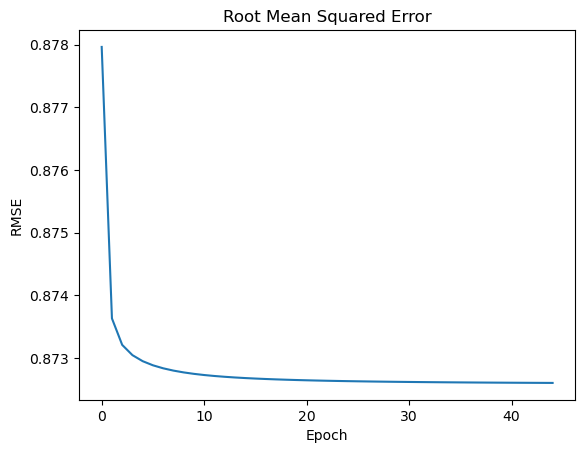

In [116]:
#plotting the RMSE
plt.plot(RMSE)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error')
plt.show()

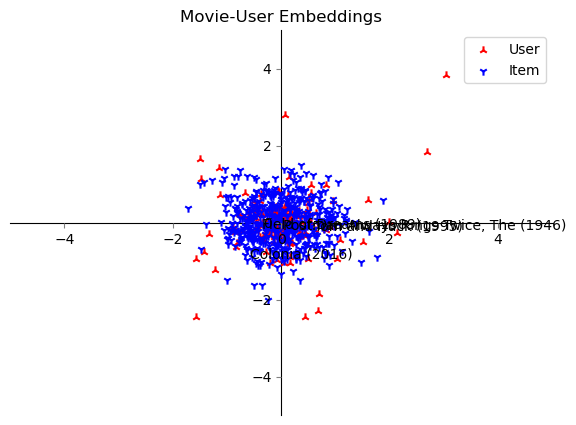

In [117]:
#Get the list of all movie titles
movie_titles = list(movies_df['title'])

# Select a random subset of 200 users and 500 movies
np.random.seed(44)
movie_subset = np.random.choice(N, size=500, replace=False)
user_subset = np.random.choice(M, size=250, replace=False)

# apply PCA to the item features and users embeddings separately
pca_item = PCA(n_components=2)
pca_user = PCA(n_components=2)
X_item_pca = pca_item.fit_transform(item_factors)
X_user_pca = pca_user.fit_transform(user_factors)

fig, ax = plt.subplots(figsize=(7, 5))

# set the limits of the x and y axes to [-1, 1]
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])

# Plot the user factors embeddings in 2D
ax.scatter(X_user_pca[user_subset, 0], X_user_pca[user_subset, 1], color = 'r', marker = '2', label = 'User')

# Plot the item factors embeddings in 2D
ax.scatter(X_item_pca[movie_subset, 0], X_item_pca[movie_subset, 1], color = 'blue', marker='1',label = 'Item')
ax.legend( loc='best')
plt.title('Movie-User Embeddings')


# move the axis lines to the center of the plot
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# set the color of the ticks to gray
ax.tick_params(axis='both', which='both', color='gray')

# set the zorder of the axis lines and change their color
ax.spines['left'].set_zorder(0)
ax.spines['bottom'].set_zorder(0)
ax.spines['left'].set_facecolor('lightgray')
ax.spines['bottom'].set_facecolor('lightgray')


# add titles for a few movies
movie_indices = [1000, 7, 5001, 9000] # assume these are the indices of the movies in your dataset
selected_movies = np.array(movie_titles)[movie_indices]

for title, index in zip(selected_movies, movie_indices):
    ax.text(X_item_pca[index, 0], X_item_pca[index, 1], title)


# show the plot
plt.show()


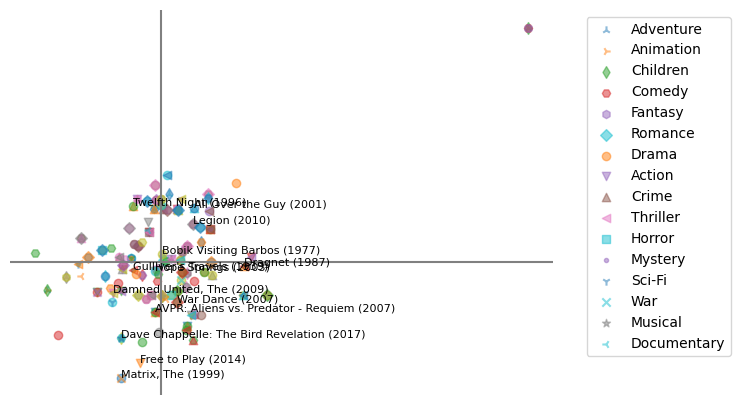

In [118]:
#Get the list of all movie titles
movie_titles = list(movies_df['title'])

# Extract the unique genre labels
genre_labels = set()
for genres in movies_df['genres']:
    genre_labels.update(genres.split('|'))
    
genre_labels = list(genre_labels)

# Encode the movie genres as binary variables using one-hot encoding
movie_genres = []
for genres in movies_df['genres']:
    one_hot = np.zeros(len(genre_labels))
    for genre in genres.split('|'):
        one_hot[genre_labels.index(genre)] = 1
    movie_genres.append(one_hot)

movie_genres = np.array(movie_genres)


# create a dictionary mapping genres to markers
genres_markers = {}
markers = ['o','.',',','x','+','v','^','<','>','1','2','3','4','s','p','*','h','H','D','d']
for i in range(len(genre_labels)):
    genres_markers[genre_labels[i]] = markers[i]
genres_markers

# Select 50 randomly sampled movie titles and their corresponding one-hot encoded genres
n_movies =100

idx = np.random.choice(len(movie_titles), n_movies, replace=False)
selected_movie_titles = np.array(movie_titles)[idx]
selected_movie_genres = movie_genres[idx, :]

# apply PCA to reduce dimensionality of movie feature vectors to 2
genres = movies_df['genres'].str.split('|')
pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)

# plot the movie feature vectors embedded in R2, tagged by genre
fig, ax = plt.subplots(figsize=(7, 5))

# add a line at x=0 and y=0
ax.axhline(y=0, color='gray', linestyle='-')
ax.axvline(x=0, color='gray', linestyle='-')

legend_labels = []
# plot the movie feature vectors embedded in R2, tagged by genre
for i in range(n_movies):
    for genre in genres[i]:
        marker = genres_markers.get(genre)
        marker_index = markers.index(marker)
        if genre not in legend_labels:
            ax.scatter(item_factors_2d[i, 0], item_factors_2d[i, 1], marker=marker, label=genre, alpha=0.5)
            legend_labels.append(genre)
        else:
             ax.scatter(item_factors_2d[i, 0], item_factors_2d[i, 1], marker=marker, alpha=0.5)
             
        
        # Add title for 10 randomly selected movies in our sampled movie list. 
        if i in np.random.choice(range(n_movies), 7):
            ax.text(item_factors_2d[i, 0], item_factors_2d[i, 1], selected_movie_titles[i], fontsize=8)
        
# Add the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='best')

# remove the axis
ax.axis('off')

# show the plot
plt.show()

In [119]:
# Create a dictionary mapping movie titles to movie IDs
id2title = dict(zip(movies_df1['movieId'], movies_df1['title']))

# Create a dictionary mapping movie IDs to movie titles
title2id = dict(zip(movies_df1['title'], movies_df1['movieId']))

movie_title = 'Lord of the Rings: The Fellowship of the Ring, The (2001)'
num_movies = 10

# Create a dummy user that gave "The Lord of the Rings: The Fellowship of the Ring" movie five stars
dummy_user = np.zeros(len(movies_df1))
dummy_user_id = title2id[movie_title]
dummy_user[dummy_user_id] = 5

# Get the latent factor for the "The Lord of the Rings: The Fellowship of the Ring" movie
movie_id = title2id[movie_title]
movie_factor = item_factors[movie_id]

# Compute the similarity between the "The Lord of the Rings: The Fellowship of the Ring" movie and all other movies
similarities = np.dot(dummy_user,item_factors)

# Get the top 10 most similar movies
top_10_similar_movies_indices = similarities.argsort()[::-1][:num_movies]
top_10_similar_movies = [id2title[i] for i in top_10_similar_movies_indices]

#Print the top 10 most similar movies
print("The top {} recommended movies for the user who watched {} are:\n".format(num_movies, movie_title))
print("\n".join(top_10_similar_movies))

The top 10 recommended movies for the user who watched Lord of the Rings: The Fellowship of the Ring, The (2001) are:

Ace Ventura: When Nature Calls (1995)
Toy Story (1995)
Father of the Bride Part II (1995)
Nixon (1995)
Sudden Death (1995)
GoldenEye (1995)
Sense and Sensibility (1995)
Sabrina (1995)
American President, The (1995)
Grumpier Old Men (1995)


In [122]:
def Top_N_recommeded_movies(N,movie_name):

    # Extract the movieId for for the watched movie
    movie_id = movies_df[movies_df['title'] == movie_name]['movieId'].values[0]

    # Extract the genres for the watched movie
    movie_genre = movies_df[movies_df['title'] == movie_name]['genres'].values[0]

    # Filter the dataset to only include movies with the same genre as the given movie
    similar_movies = movies_df[movies_df['genres'] == movie_genre]

    # Computing the similarity between the given movie and the other movies based on the ALS model
    similar_movies = similar_movies.copy()
    movie_vec = item_factors[movie_id]
    similar_movies['similarity'] = similar_movies['movieId'].apply(lambda x: np.dot(item_factors[x], movie_vec))

    # Sort the resulting dataset by the similarity.
    similar_movies = similar_movies.sort_values('similarity', ascending=False)

    # Select the top N movies from the resulting dataset.
    top_n_movies = similar_movies[(similar_movies['title'] != movie_name)].head(N)

    rec_movies = list(top_n_movies['title'])

    return rec_movies

Movies = Top_N_recommeded_movies(10,movie_title)

In [125]:
movieIDS, movieGs = [], []
for movie in Movies:
    mID = movies_df[movies_df['title']==movie]['movieId'].values[0]
    genre = movies_df[movies_df['title']==movie]['genres'].values[0]
    movieIDS.append(mID), movieGs.append(genre)
DF =  pd.DataFrame({'movieId': movieIDS, 'title': Movies, 'Genres': movieGs})
DF


,movieId,title,Genres
0,6955,Fire and Ice (2008),Adventure|Fantasy
1,1598,"Dark Crystal, The (1982)",Adventure|Fantasy
2,4137,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
3,8617,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy
4,9218,Gods of Egypt (2016),Adventure|Fantasy
5,7261,Percy Jackson & the Olympians: The Lightning T...,Adventure|Fantasy
6,6912,Dinotopia (2002),Adventure|Fantasy
7,4076,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
8,4152,"Thief of Bagdad, The (1940)",Adventure|Fantasy
9,6957,Inkheart (2008),Adventure|Fantasy


##### **Conclusion**

In conclusion, we have successfully built a movie recommendation system using the Alternating Least Squares (ALS) algorithm which provides personalized movie recommendations based on a user's viewing history.  Through the use of feature vectors and latent factors, the model is able to identify and recommend movies with similar features to those that the user has already enjoyed. Our model was trained on the MovieLens 100K dataset, and we were able to make personalized movie recommendations for users based on their viewing history.

The results of our movie recommendation system are promising, with the ALS algorithm being able to accurately predict movie ratings for users. The RMSE score of our model is quite low, indicating that it is able to make accurate predictions with a high degree of confidence. This suggests that the algorithm has been able to capture meaningful patterns in the movie ratings data and use them to generate useful recommendations. We also explored the most and least polarizing movies based on the variance of their ratings, which can help us understand which movies are likely to be controversial among viewers. This information can be used to fine-tune recommendations based on a user's preferences and avoid recommending polarizing movies to users who are unlikely to enjoy them.